In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.cm as cm
from matplotlib import colormaps
from matplotlib.colors import Normalize


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.stats import diagnostic

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Wczytywanie danych

In [8]:
database = pd.read_csv('car_prices.csv')
print(f"Rozmiar wczytanych danych:{database.shape[0]} x {database.shape[1]}")

Rozmiar wczytanych danych:558837 x 16


# Czyszczenie danych

Ujednolicenie marek pojazdów poprzez ustawienie pierwszej litery marki na wielką oraz rozszerzenie nazw.

In [9]:
database.loc[:, 'make'] = database['make'].str.title()
database.loc[:, 'make'] = database['make'].replace({'Vw': 'Volkswagen', 'Mercedes-B':'Mercedes-Benz','Mercedes':'Mercedes-Benz','Dodge': 'Dodge Tk'})

Usunięcie wierszy zawierających wartości N/A w kolumnie 'mmr' oraz 'sellingprice'

In [10]:
database = database.dropna(subset=['make','mmr','sellingprice'],axis='rows')
database.shape

(548498, 16)

# Pokazanie ilości sprzedanych pojazdów wg.marki produkcji

Na poniższym wykresie słupkowym pokazano ilość sprzedanych pojazdów pogrupowanych wg marki produkcji. Najwięcej sprzedanych aut pochodziło z takich firm jak Ford, Nissan czy Toyota.

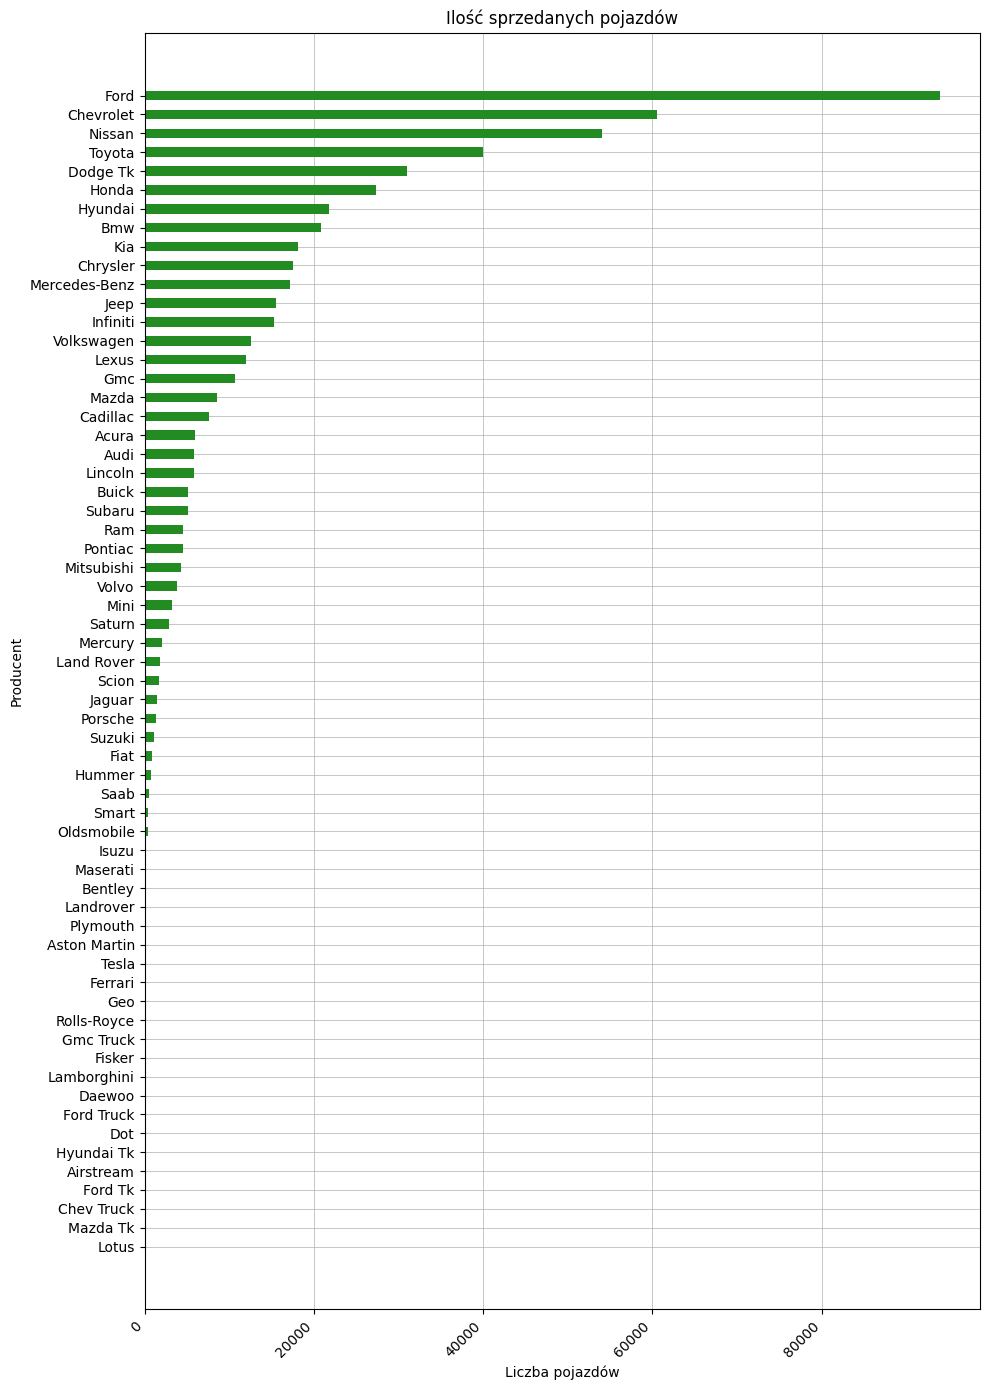

In [11]:
model_car_sum = database['make'].value_counts()
model_car_filtered = model_car_sum[model_car_sum>0]

plt.figure(figsize=(10, 14))
plt.barh(model_car_filtered.index, model_car_filtered.values, height=0.5,color='forestgreen', zorder=2)
plt.xlabel('Liczba pojazdów')
plt.ylabel('Producent')
plt.title('Ilość sprzedanych pojazdów')
plt.xticks(rotation=45, ha='right')
plt.gca().invert_yaxis()
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.tight_layout()
plt.show()

# Pokazanie rozkładu roku produkcji sprzedanych aut

Poniższy wykres przedstawia rok produkcji sprzedawanych aut. Widzimy na nim, iż ilość dokonanych transakcji jest rosnąca z wyłączeniem okresu lat 2008-2009 co pokrywa się z czasem wystąpienia wielkiego kryzysu gospodarczego.

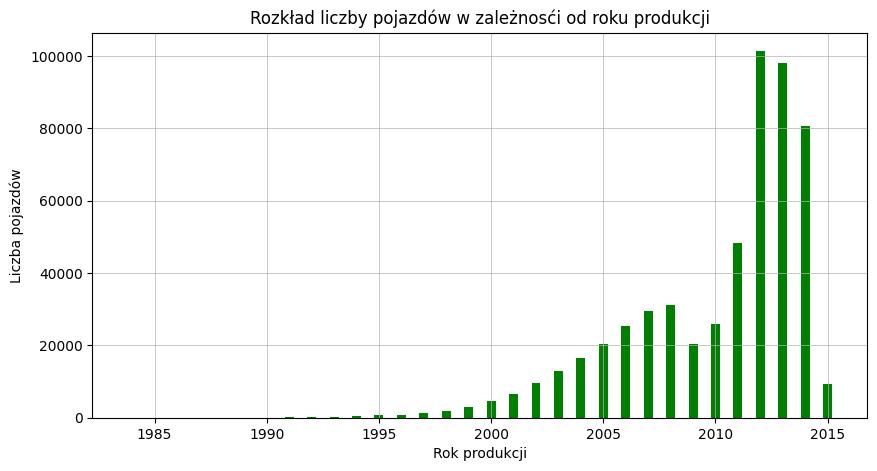

In [12]:
df_age = database['year'].value_counts()

fig = plt.figure(figsize = (10, 5))
 
years = df_age.index
counts = df_age.values

plt.bar(years, counts, color='green', width=0.4)

plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
 
plt.xlabel("Rok produkcji")
plt.ylabel("Liczba pojazdów")
plt.title("Rozkład liczby pojazdów w zależnosći od roku produkcji")
plt.show()

# Średni uśredniony przebieg pojazdu pogrupowany wg marki

Na wykresie możemy zaobserwować iż pojazdami z największym przebiegiem są te pochądzące z popularnych w USA marek jak Fors czy chevrolet. Zaś najmniejszy przebieg prezentują pojazdy z marek niszowych lub luksusowych, których pojazdy nie są wykorzystywane jako narzędzie pracy.

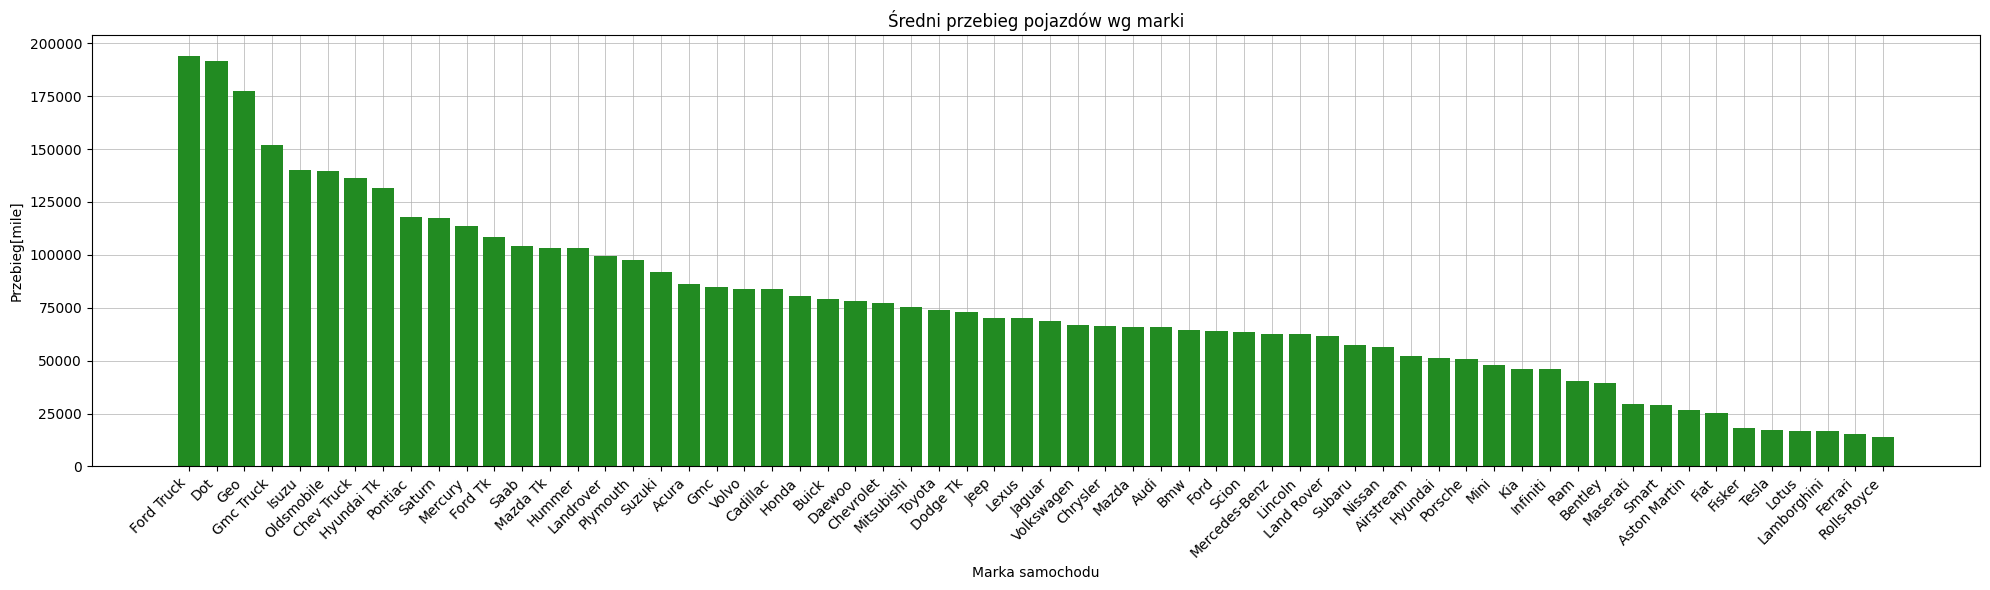

In [13]:
mean_odometer = database.groupby('make')['odometer'].mean()
mean_odometer_sorted = mean_odometer.sort_values(ascending=False)

plt.figure(figsize=(20, 6))
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.bar(mean_odometer_sorted.index, mean_odometer_sorted.values, color='forestgreen', zorder=2)
plt.xlabel('Marka samochodu')
plt.ylabel('Przebieg[mile]')
plt.title('Średni przebieg pojazdów wg marki')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


# Średni wiek pojazdu

Uśredniony rok produkcji samochodu(na podstawie wszystkich wpisów dla poszczególnej marki) pogrupowanych według marki pojazdu. Widać na nim, iż najmłodzsze pojazdy pochodzą z fabryki Tesli, zaś najstarszymi jednostkami w użyciu są np. Fordy.

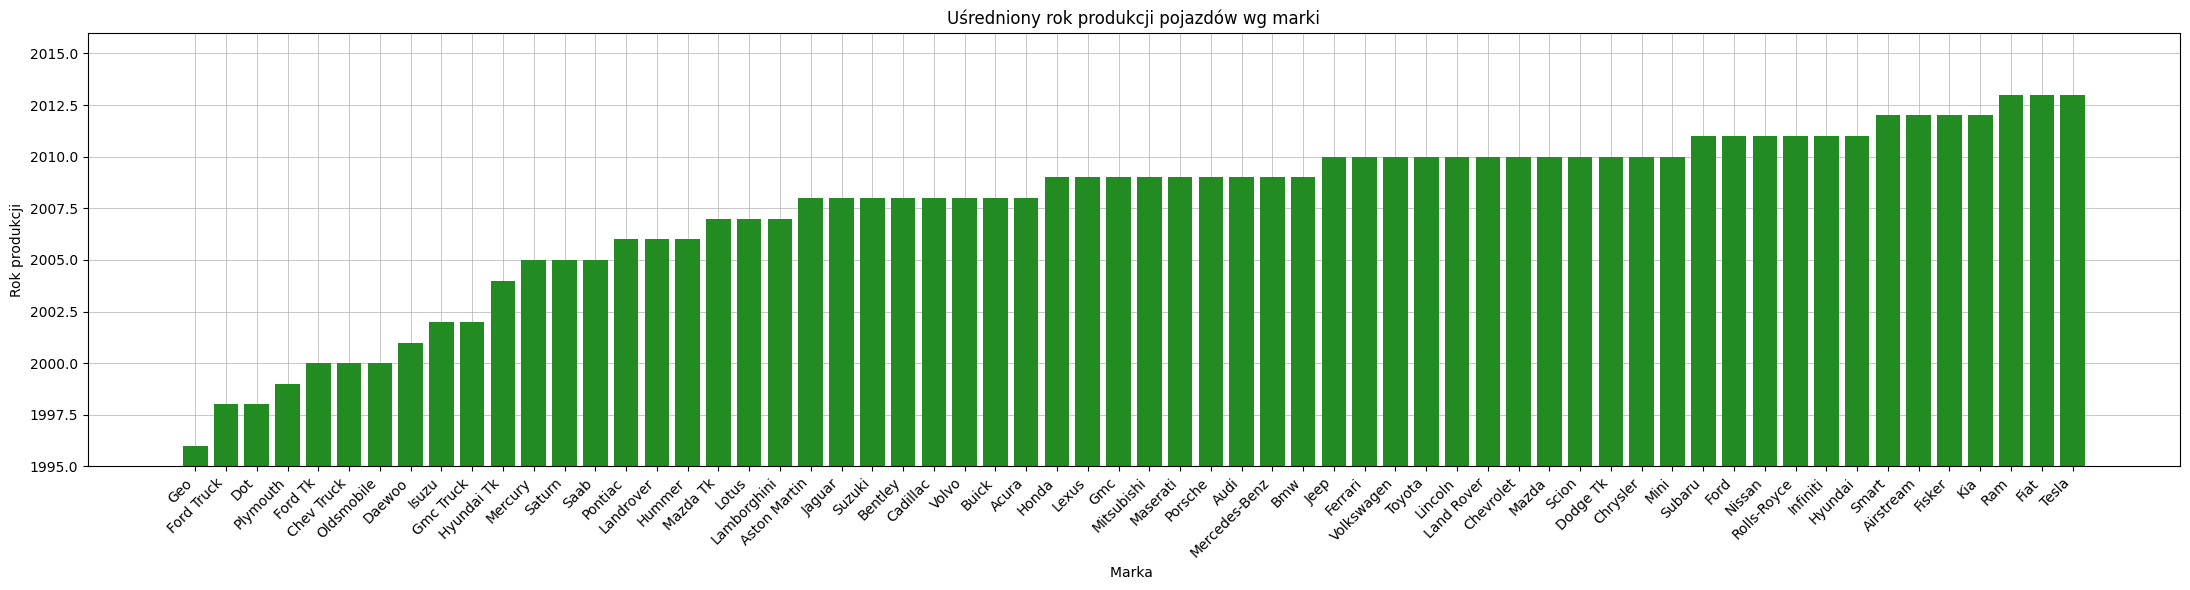

In [15]:

mean_age = database.groupby('make')['year'].mean()
mean_age_sorted = mean_age.sort_values(ascending=True).round().astype(int)


plt.figure(figsize=(22, 6))
plt.bar(mean_age_sorted.index, mean_age_sorted.values, color='forestgreen', zorder=2)
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.xlabel('Marka ')
plt.ylabel('Rok produkcji')
plt.title('Uśredniony rok produkcji pojazdów wg marki')
plt.xticks(rotation=45, ha='right')
plt.ylim(1995, 2016)
plt.tight_layout()
plt.show()

# Średnia cena pojazdu wg marki

Średnia cena pojazdów w zależności od marki. Najdroższą marką jest Rolls-Royce, który wyprzedził w tym zestawieniu Ferrari.

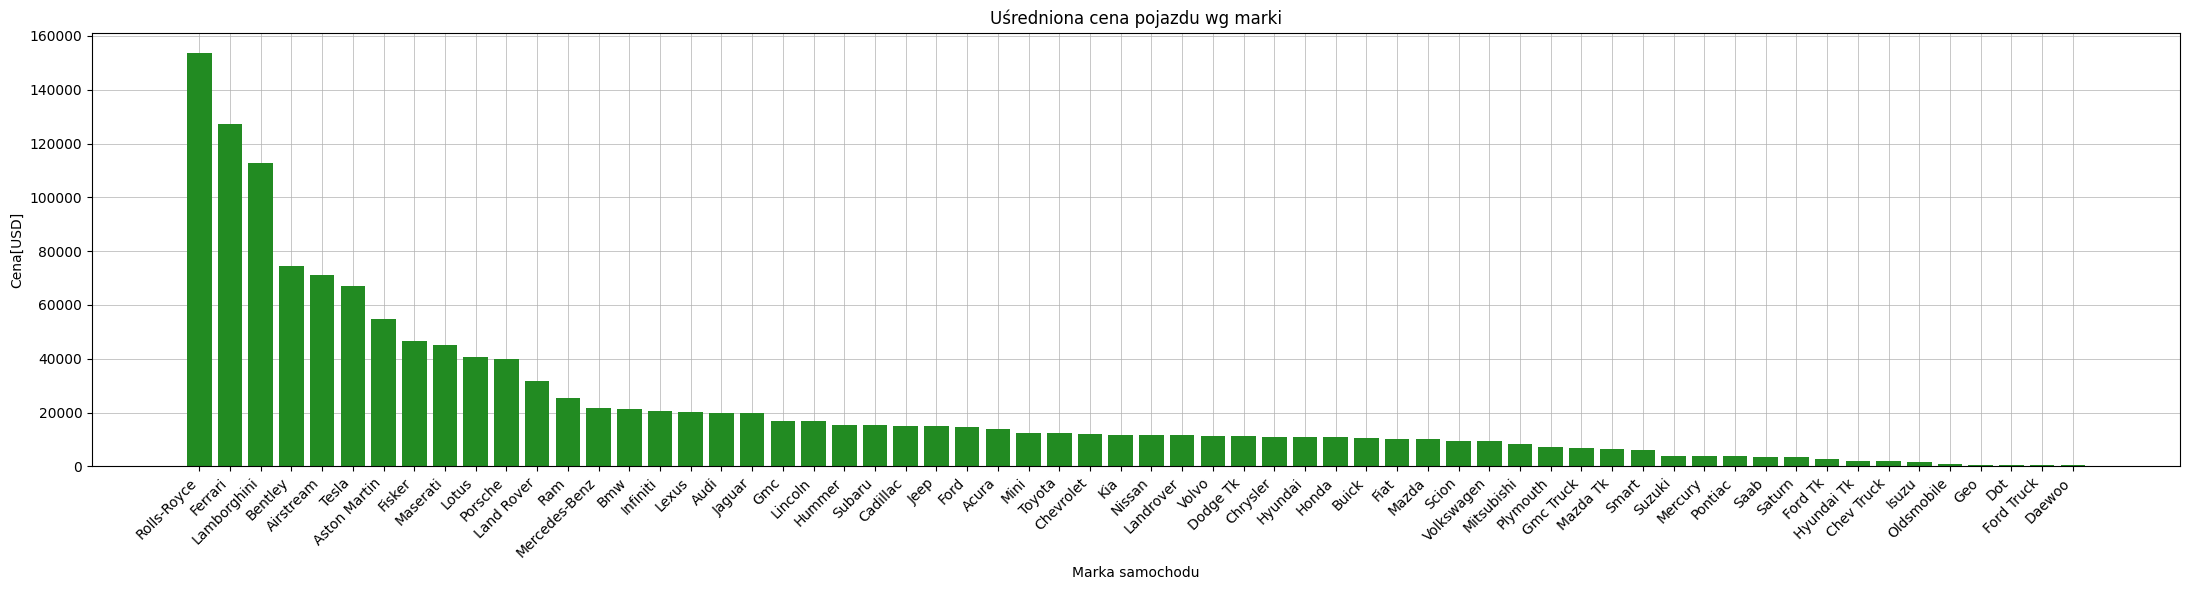

In [10]:
mean_price = database.groupby('make')['sellingprice'].mean()
mean_price_sorted = mean_price.sort_values(ascending=False).round().astype(int)


plt.figure(figsize=(22, 6))
plt.bar(mean_price_sorted.index, mean_price_sorted.values, color='forestgreen', zorder=2)
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.xlabel('Marka samochodu')
plt.ylabel('Cena[USD]')
plt.title('Uśredniona cena pojazdu wg marki')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 10 najdroższych marek pojazdów wraz z 5 najcenniejszymi modelami

Poniższy wykres przedstawia 10 marek, których cena sprzedanych pojazdów była największa. Poszczególne wykresy prezentują od jednego do 5 modeli pojazdów, które zostały sprzedane. Bezpośrednio na wykresie widzimy  średnią cenę oraz model samochodu. Ponownie pojazdy marki Rolls-Royce okazały się najdroższymi, a zestawienie zamyka firma Porsche ze swoimi modelami.

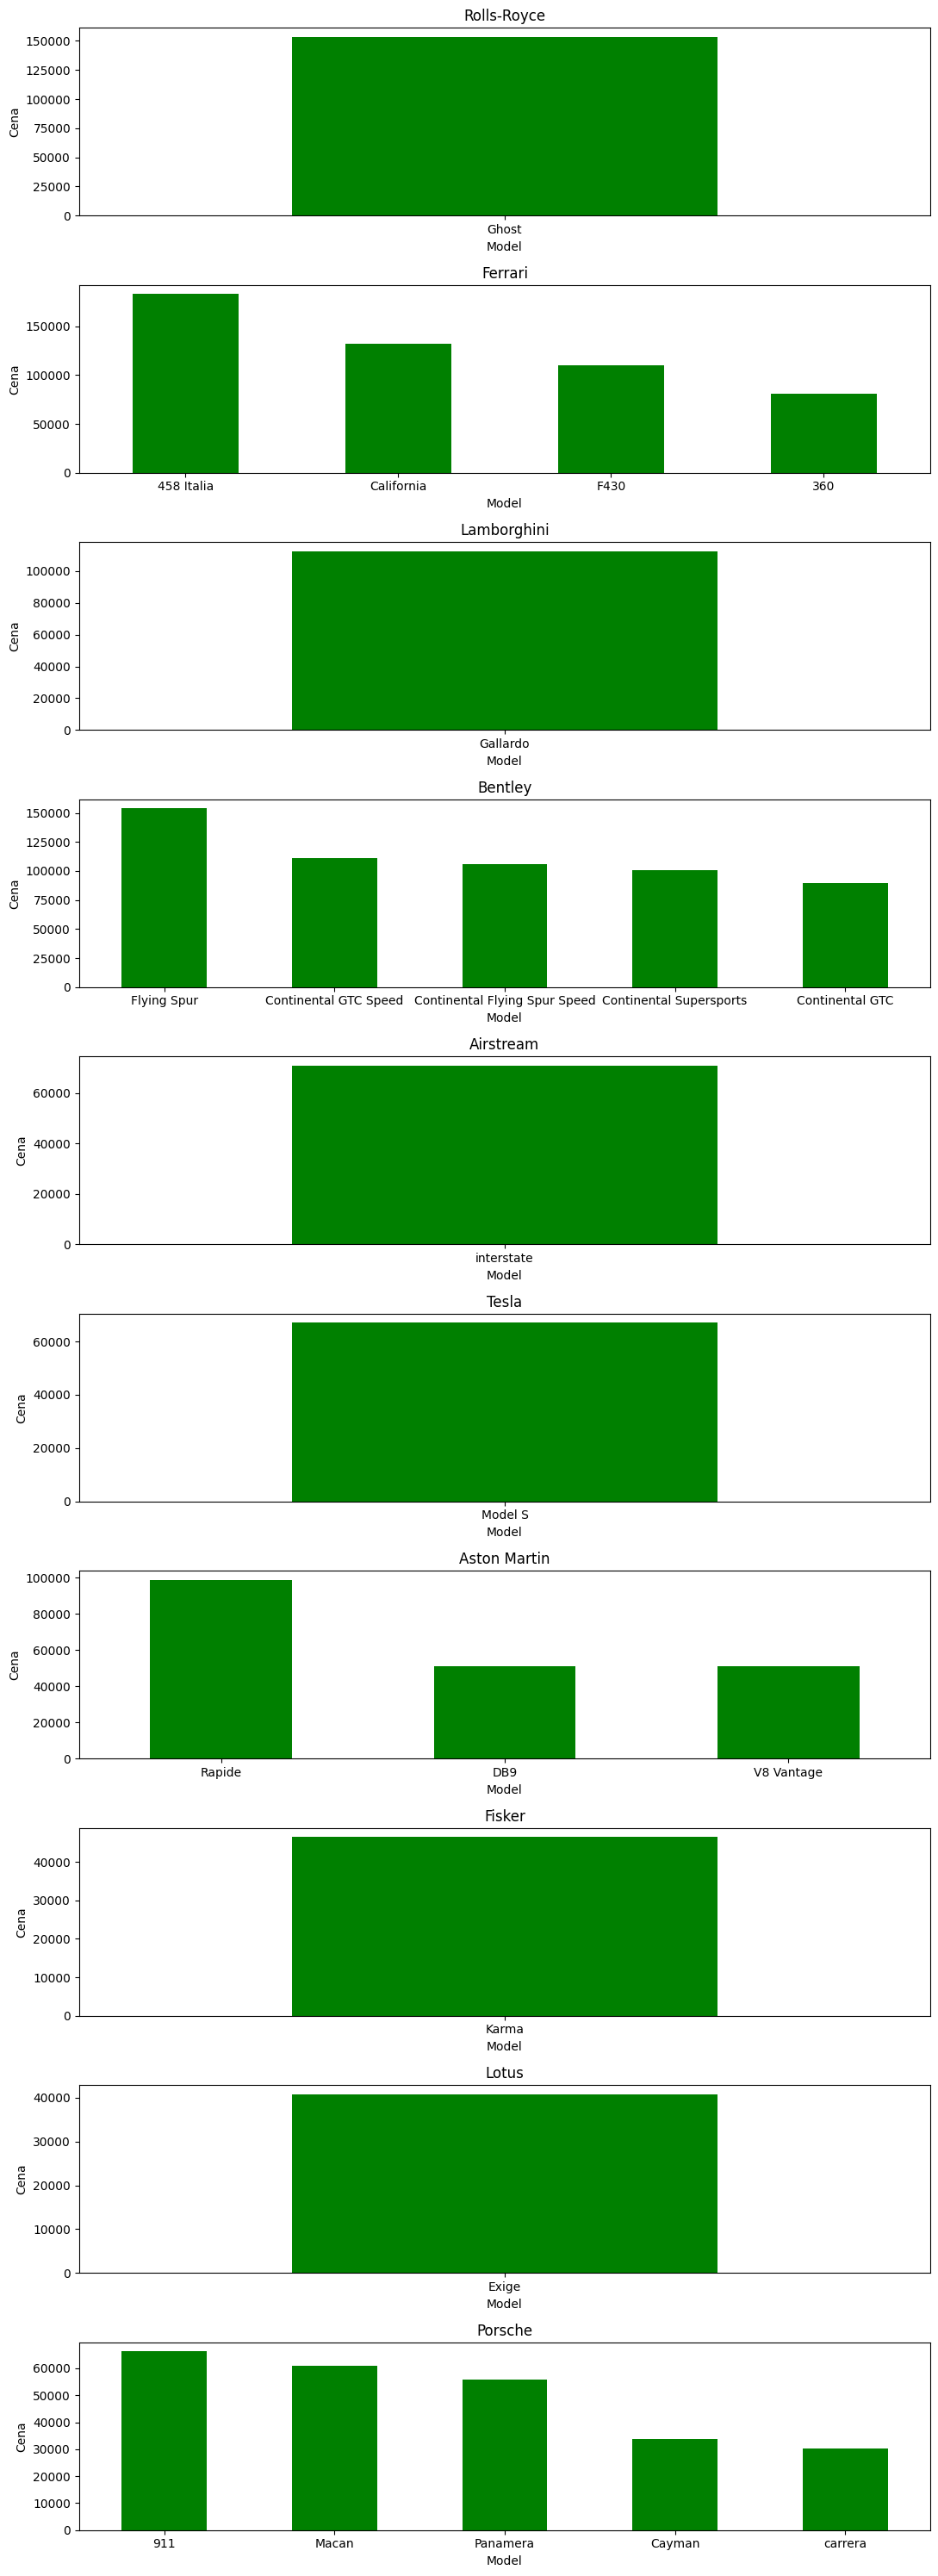

In [25]:
average_prices = database.groupby(['make', 'model'])['sellingprice'].mean()

top_makes = average_prices.groupby('make').mean().nlargest(10)

fig, axes = plt.subplots(nrows=len(top_makes), ncols=1, figsize=(11, 3 * len(top_makes)))

for i, (make, avg_price) in enumerate(top_makes.items()):
    top_models = average_prices.loc[make].nlargest(5)
    
    top_models.plot(kind='bar', ax=axes[i], color='green')
    
    axes[i].set_title(make)
    axes[i].set_ylabel('Cena')
    axes[i].set_xlabel('Model')
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


# Regresja liniowa kwoty wyceny i sprzedaży auta

Każdy z punktów prezentuje cenę pojazdu w momencie wyceny oraz sprzedaży. Większość z nich położona jest wzdłuż wyznaczonej linii, oznaczająćej że obydwie kwoty są takie same. Im niższa była wartość pojazdu, tym różnica pomiędzy tymi dwiema wartościami była większa. Wystąpiły również przypadki, gdzie cena wyceny a sprzedaży różniły się w znacznym stopniu. 

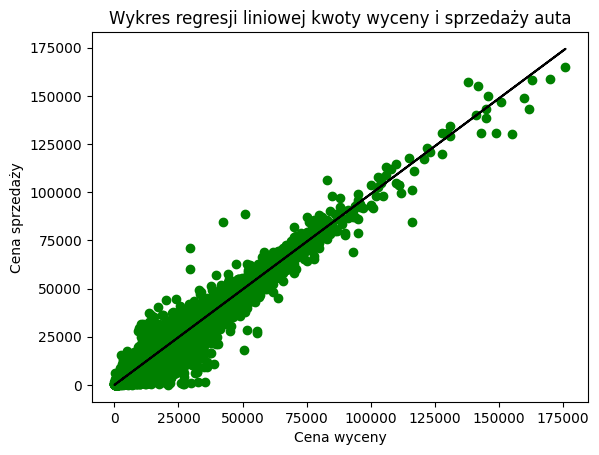

In [12]:
from sklearn.linear_model import LinearRegression

data = database.dropna(axis='rows', subset=['mmr', 'sellingprice', 'make'])

X = data['mmr'].values.reshape(-1,1)
y = data['sellingprice']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state = 1410)

reg = LinearRegression().fit(X_train, y_train)
res = reg.score(X_test, y_test)

y_pred = reg.predict(X_test)
plt.scatter(X_test, y_test, color ='green')
plt.plot(X_test, y_pred, color ='k')
plt.title('Wykres regresji liniowej kwoty wyceny i sprzedaży auta')

plt.xlabel('Cena wyceny')
plt.ylabel('Cena sprzedaży')
 
plt.show()



# Korelacja pomiędzy poszczególnymi rodzajami danych

Korelacja pozwala na określenie wzajemnego powiązania pomiędzy wybranymi zmiennymi. Najbardziej powiązanymi zmiennymi był cena sprzedaży(sellingprice) oraz cena wyceny pojazdu(mmr).

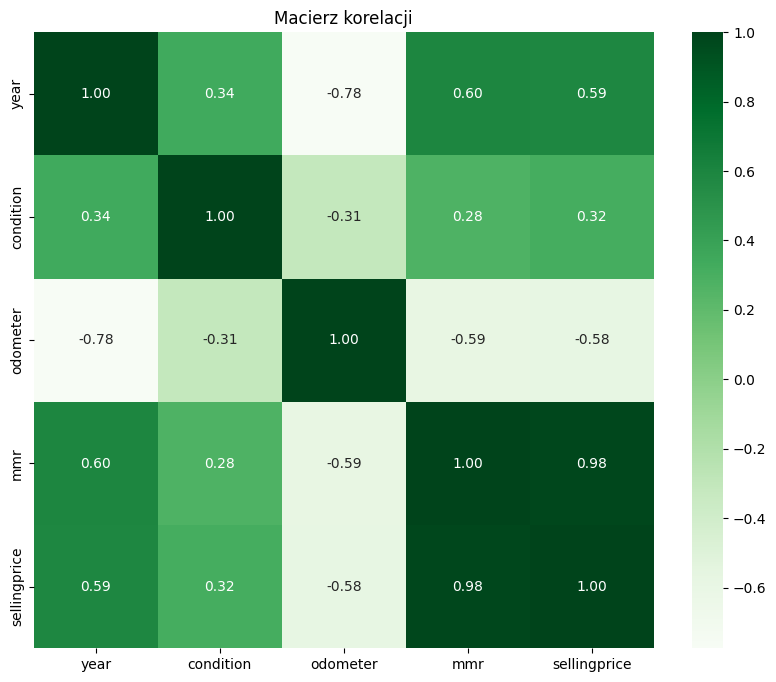

In [13]:
import pandas as pd

data_corr = pd.DataFrame(database)

numeric_data = data_corr.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f")

plt.title('Macierz korelacji')

plt.show()

Predykcja ceny sprzedaży samochodów wykonana za pomocą algorytmu Drzew decyzyjnych

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

data_Tree_price = data.copy()

X = data_Tree_price['make']
y = data_Tree_price['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

X_2d = X.values.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
X_encoded = encoder.fit_transform(X_2d)

c:\Users\micha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Mean Absolute Error (MAE): 6327.528307379424
Mean Squared Error (MSE): 74766788.40398172
Root Mean Squared Error (RMSE): 8646.779076857561
Mean Absolute Percentage Error (MAPE): 1.6583822202328715


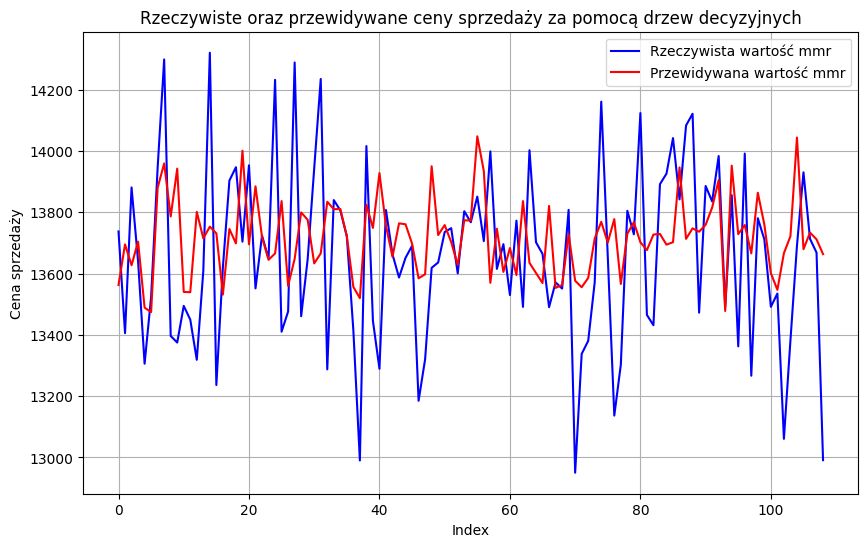

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=1410)
tree_model = DecisionTreeRegressor(random_state=1410)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

tree_metric = mean_absolute_percentage_error(y_test, y_pred)
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

y_test_avg = y_test.groupby(y_test.index // 10).mean()
y_pred_avg = pd.Series(y_pred).groupby(pd.Series(y_pred).index // 10).mean()
bins = np.arange(0, len(y_test) + 1, 1000)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Przewidywana wartość mmr', color='red')
plt.xlabel('Index')
plt.ylabel('Cena sprzedaży')
plt.title('Rzeczywiste oraz przewidywane ceny sprzedaży za pomocą drzew decyzyjnych')
plt.legend()
plt.grid()

plt.show()


Predykcja ceny MMR samochodów wykonana za pomocą algorytmu Drzew decyzyjnych
MMR - To narzędzie, które śledzi ceny samochodów na rynku wtórnym. To przydatne narzędzie dla dealerów samochodowych, kupujących i sprzedających, ponieważ dostarcza aktualnych informacji na temat wartości rynkowej różnych modeli samochodów. MMR zbiera dane z transakcji na aukcjach samochodowych oraz innych źródeł, aby określić przeciętne ceny pojazdów i trendów cenowych.

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

data_Tree = data

X = pd.get_dummies(data_Tree['make'])
y = data_Tree['mmr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)
tree_model = DecisionTreeRegressor(random_state=1410)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)



tree_metric = mean_absolute_percentage_error(y_test, y_pred)
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

y_test_avg = y_test.groupby(y_test.index // 10).mean()
y_pred_avg = pd.Series(y_pred).groupby(pd.Series(y_pred).index // 10).mean()
print('Jakość predykcji:', tree_metric)


Mean Absolute Error (MAE): 6230.7826830588465
Mean Squared Error (MSE): 73133298.74869561
Root Mean Squared Error (RMSE): 8551.80090675032
Mean Absolute Percentage Error (MAPE): 1.2876707258533855
Jakość predykcji: 1.2876707258533855


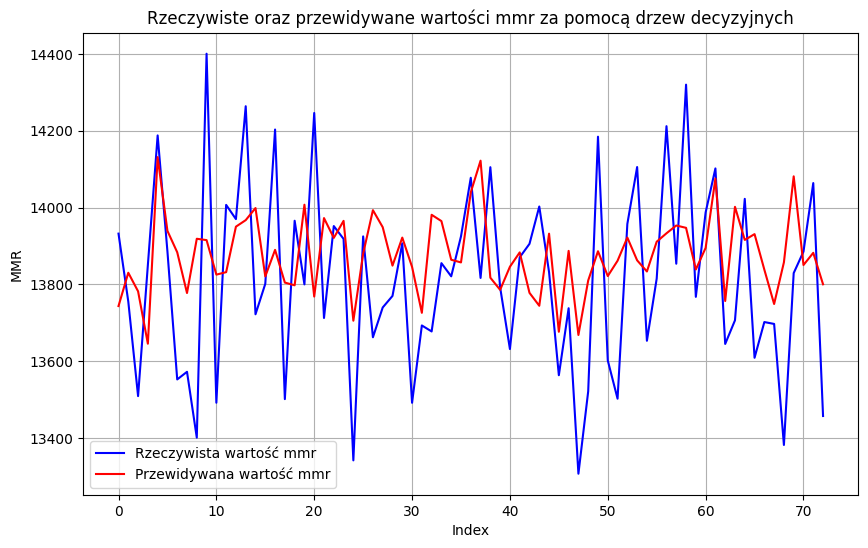

In [17]:
bins = np.arange(0, len(y_test) + 1, 1500)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Przewidywana wartość mmr', color='red')


plt.xlabel('Index')
plt.ylabel('MMR')
plt.title('Rzeczywiste oraz przewidywane wartości mmr za pomocą drzew decyzyjnych')
plt.legend()
plt.grid()

plt.show()

In [18]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Error (MAE): 6230.7826830588465
Mean Squared Error (MSE): 73133298.74869561
Root Mean Squared Error (RMSE): 8551.80090675032
Mean Absolute Percentage Error (MAPE): 1.2876707258533855


Predykcja ceny MMR samochodów wykonana za pomocą algorytmu MLP

In [19]:
from sklearn.neural_network import MLPRegressor
data_MLP = data

X = pd.get_dummies(data_MLP['make'])
y = data_MLP['mmr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

mlp_model = MLPRegressor(hidden_layer_sizes=10)
mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)


result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

c:\Users\micha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Absolute Error (MAE): 6243.156338961897
Mean Squared Error (MSE): 74591575.50537327
Root Mean Squared Error (RMSE): 8636.641448235145
Mean Absolute Percentage Error (MAPE): 1.2896730319524978


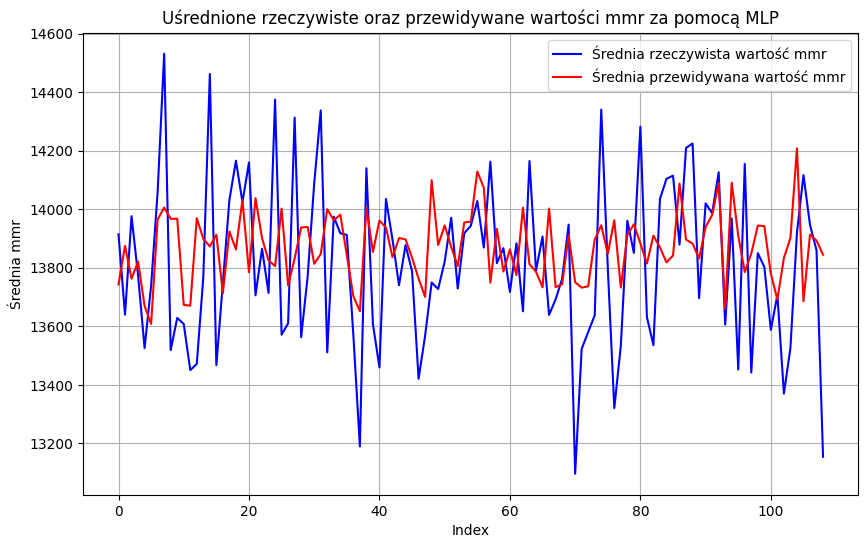

In [20]:
bins = np.arange(0, len(y_test) + 1, 1000)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Średnia rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Średnia przewidywana wartość mmr', color='red')


plt.xlabel('Index')
plt.ylabel('Średnia mmr')
plt.title('Uśrednione rzeczywiste oraz przewidywane wartości mmr za pomocą MLP')
plt.legend()
plt.grid()

plt.show()

Predykcja ceny MMR samochodów wykonana za pomocą algorytmu KNN

In [21]:
from sklearn.neighbors import KNeighborsRegressor

data_KNN = data

X = pd.get_dummies(data_KNN['make'])
y = data_KNN['mmr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Mean Absolute Error (MAE): 6243.156338961897
Mean Squared Error (MSE): 74591575.50537327
Root Mean Squared Error (RMSE): 8636.641448235145
Mean Absolute Percentage Error (MAPE): 1.2896730319524978


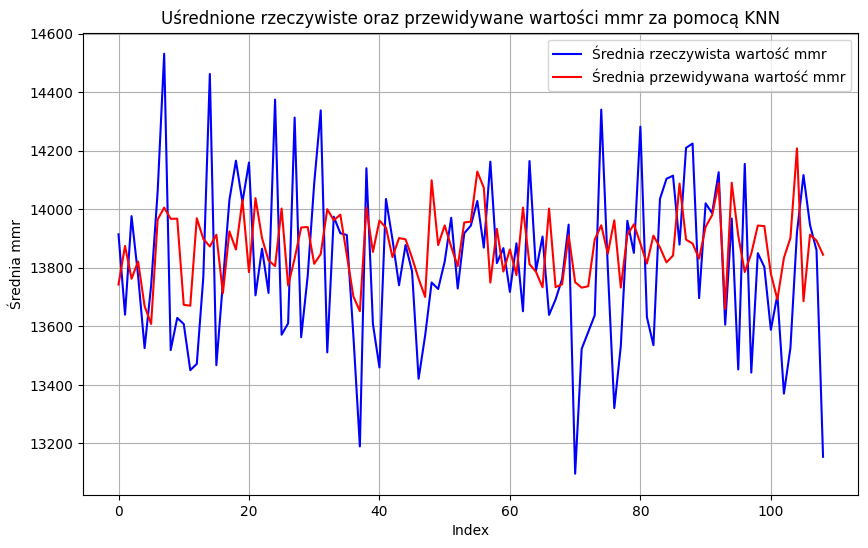

In [22]:
bins = np.arange(0, len(y_test) + 1, 1000)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Średnia rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Średnia przewidywana wartość mmr', color='red')


plt.xlabel('Index')
plt.ylabel('Średnia mmr')
plt.title('Uśrednione rzeczywiste oraz przewidywane wartości mmr za pomocą KNN')
plt.legend()
plt.grid()

plt.show()